In [1]:
import pandas as pd
import numpy as np
#To get date time
import datetime as dt
#For plotting purposes
import matplotlib.pyplot as plt
# set options
pd.options.display.max_colwidth = 50
pd.set_option('display.max_colwidth', -1) 
pd.options.mode.chained_assignment = None  # default='warn'

## Loading data

In [99]:
#This is the file generated after preprocessing and LDA
food_reviews = pd.read_csv('processd_food_reviews.txt', sep = '\t')

In [3]:
food_reviews = food_reviews.iloc[ : , 1 : len(food_reviews.columns)]
food_reviews.tail()

,productid,userid,username,time,year,month,helpful_upvotes,helpful_responses,helpfulness_score,rating,sentiment,text_ext,summary,text
525530,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,2011-03-09,2011,3,0.0,0.0,-1.0,5.0,1,Will not do without Great for sesame chicken..this is a good if not better than resturants I have eaten at..My husband loved it..will find other recipes to use this in..,Will not do without,Great for sesame chicken..this is a good if not better than resturants I have eaten at..My husband loved it..will find other recipes to use this in..
525531,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,2012-03-09,2012,3,0.0,0.0,-1.0,2.0,0,"disappointed I'm disappointed with the flavor. The chocolate notes are especially weak. Milk thickens it but the flavor still disappoints. This was worth a try but I'll never buy again. I will use what's left, which will be gone in no time thanks to the small cans.",disappointed,"I'm disappointed with the flavor. The chocolate notes are especially weak. Milk thickens it but the flavor still disappoints. This was worth a try but I'll never buy again. I will use what's left, which will be gone in no time thanks to the small cans."
525532,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2012-02-21,2012,2,2.0,2.0,1.0,5.0,1,"Perfect for our maltipoo These stars are small, so you can give 10-15 of those in one training session. I tried to train our dog with ""Ceaser dog treats"", it just made our puppy hyper. If you compare the ingredients, you will know why. Little stars has just basic food ingredients without any preservatives and food coloring. Sweet potato flavor also did not make my hand smell like dog food.",Perfect for our maltipoo,"These stars are small, so you can give 10-15 of those in one training session. I tried to train our dog with ""Ceaser dog treats"", it just made our puppy hyper. If you compare the ingredients, you will know why. Little stars has just basic food ingredients without any preservatives and food coloring. Sweet potato flavor also did not make my hand smell like dog food."
525533,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",2012-03-13,2012,3,1.0,1.0,1.0,5.0,1,Favorite Training and reward treat These are the BEST treats for training and rewarding your dog for being good while grooming. Lower in calories and loved by all the doggies. Sweet potatoes seem to be their favorite Wet Noses treat!,Favorite Training and reward treat,These are the BEST treats for training and rewarding your dog for being good while grooming. Lower in calories and loved by all the doggies. Sweet potatoes seem to be their favorite Wet Noses treat!
525534,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,2012-05-31,2012,5,0.0,0.0,-1.0,5.0,1,"Great Honey I am very satisfied ,product is as advertised, I use it on cereal, with raw vinegar, and as a general sweetner.",Great Honey,"I am very satisfied ,product is as advertised, I use it on cereal, with raw vinegar, and as a general sweetner."


## Pre-processing data

* renaming columns
* checking datatype
* dealing with null values - impute for summary, removal of rest
* reindexing of data
* conversion of timestamp to date
* features - creation of helfulness_score, extended review
* removal of neutral reviews - with rating 3
* classificaton of positive and negative sentiment into 0 and 1

## Taking a sample of 1% data and carrying out model building on it!

In [4]:
food_review_sample = food_reviews.sample(frac = 0.01)

In [5]:
food_review_sample.shape

(5255, 14)

In [6]:
len(food_review_sample.productid.unique())

4013

#### Carrying out LDA on it

#### Text Processing - Conversion to lower case, stemming, stop words removal, and punctuations. 

In [7]:
#Package for stemming and getting stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [8]:
#Packages for word tokenization and getting the word2vec
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [9]:
#Packages to perform logisic regression and perform cross- validation
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import cross_validation
from sklearn.metrics import f1_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
#Using porter stemmer to stem the words
stemmer = PorterStemmer()
food_review_sample['review_tokens'] = food_review_sample['text'].str.lower().apply(lambda x: word_tokenize(x))
food_review_sample['review_tokens'] = food_review_sample['review_tokens'].apply(lambda x: [stemmer.stem(words) for words in x])

In [11]:
def remove_punctuations_and_stopwords(x):
    #This function iterates through a list and removes any words that are punctuations or stopwords.
    y = []
    stop_words = set(stopwords.words('english'))
    for i in range(len(x)):
        if x[i].isalnum() and x[i] not in stop_words:
            y.extend([x[i]])
    return y        

In [12]:
food_review_sample['review_tokens'] = food_review_sample['review_tokens'].apply(remove_punctuations_and_stopwords)

In [13]:
#Package to pre process
import gensim
from gensim.utils import simple_preprocess

In [14]:
#Builds a corpus of words
dictionary = gensim.corpora.Dictionary(food_review_sample.review_tokens)
bow_corpus = [dictionary.doc2bow(doc) for doc in food_review_sample.review_tokens]

In [15]:
#Building the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(bow_corpus, num_topics = 50, id2word=dictionary, passes=15, minimum_probability= 0)

In [16]:
#Gets the lda in a useable dataframe
lda_df = pd.DataFrame()
for i in range(0, len(food_review_sample)):
    lda_df = pd.concat([lda_df, pd.DataFrame(ldamodel.get_document_topics(bow_corpus[i]))[1]], axis=1)
    
lda_df = lda_df.transpose()    

In [17]:
#Performing logistic regression with 10-fold CV
predicted = cross_validation.cross_val_predict(LogisticRegression(), lda_df, food_review_sample['sentiment'], cv=10)
print(metrics.accuracy_score(food_review_sample['sentiment'], predicted))

0.8485252140818268


84.85% Accuracy.

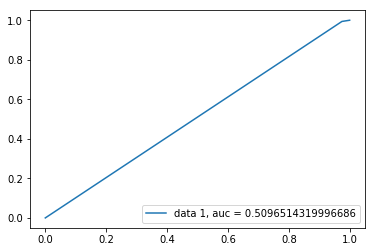

In [20]:
#Code to print the ROC curve
fpr, tpr, _ = metrics.roc_curve(food_review_sample['sentiment'],  predicted)
auc = metrics.roc_auc_score(food_review_sample['sentiment'], predicted)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc)) #Area under curve
plt.legend(loc=4)
plt.show()

In [25]:
#Calculating the f1 score
f1_score(food_review_sample['sentiment'], predicted, average='weighted')  

0.7871128390038634

#### Carrying the same analysis on the extended text column

In [26]:
#Lower casing, tokenizing, stemmatization, and removing punctuations and stopwords
food_review_sample['review_tokens'] = food_review_sample['text_ext'].str.lower().apply(lambda x: word_tokenize(x))
food_review_sample['review_tokens'] = food_review_sample['review_tokens'].apply(lambda x: [stemmer.stem(words) for words in x])
food_review_sample['review_tokens'] = food_review_sample['review_tokens'].apply(remove_punctuations_and_stopwords)

In [27]:
#Building a corpus
dictionary = gensim.corpora.Dictionary(food_review_sample.review_tokens)
bow_corpus = [dictionary.doc2bow(doc) for doc in food_review_sample.review_tokens]

In [28]:
#Making the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(bow_corpus, num_topics = 50, id2word=dictionary, passes=15, minimum_probability= 0)

In [29]:
lda_df = pd.DataFrame()
for i in range(0, len(food_review_sample)):
    lda_df = pd.concat([lda_df, pd.DataFrame(ldamodel.get_document_topics(bow_corpus[i]))[1]], axis=1)
    
lda_df = lda_df.transpose()    

In [30]:
#Performing logistic regression with 10-fold CV
predicted = cross_validation.cross_val_predict(LogisticRegression(), lda_df, food_review_sample['sentiment'], cv=10)
print(metrics.accuracy_score(food_review_sample['sentiment'], predicted))

0.8610846812559467


86.1% Accuracy.

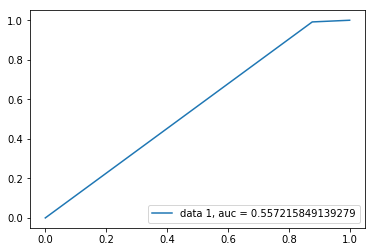

In [31]:
#Code to print the ROC curve
fpr, tpr, _ = metrics.roc_curve(food_review_sample['sentiment'],  predicted)
auc = metrics.roc_auc_score(food_review_sample['sentiment'], predicted)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc)) #Area under curve
plt.legend(loc=4)
plt.show()

In [32]:
f1_score(food_review_sample['sentiment'], predicted, average='weighted')  

0.8166618048497607

It is clear that extended text is a better predictor in this case. Sticking to that.

#### Implementing decision tree instead of logistic regression on the lda data frame 

In [79]:
from sklearn import tree

In [90]:
from random import sample
test_index = sample(range(0, len(food_review_sample)), int(0.7 * len(food_review_sample)))

In [95]:
valid_index = [item for item in food_review_sample.index if item not in test_index]

In [94]:
#Building the decision tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(lda_df.iloc[test_index], food_review_sample.iloc[test_index]['sentiment'])

In [96]:
metrics.accuracy_score(food_review_sample.iloc[valid_index]['sentiment'], clf.predict(lda_df.iloc[valid_index]))

0.7907419150285352

Accuracy of 79.07%

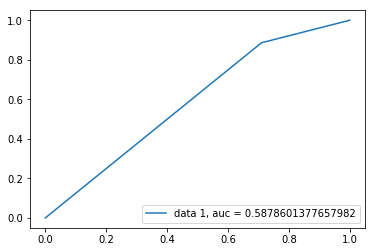

In [97]:
#Code to print the ROC curve
fpr, tpr, _ = metrics.roc_curve(food_review_sample.iloc[valid_index]['sentiment'],  clf.predict(lda_df.iloc[valid_index]))
auc = metrics.roc_auc_score(food_review_sample.iloc[valid_index]['sentiment'],  clf.predict(lda_df.iloc[valid_index]))
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc)) #Area under curve
plt.legend(loc=4)
plt.show()

In [98]:
f1_score(food_review_sample.iloc[valid_index]['sentiment'],  clf.predict(lda_df.iloc[valid_index]), average='weighted')  

0.7856812211052039

As the decision trees give worse results than the logistic regression on the lda, we won't use it

#### TF-IDF on the sample

In [33]:
from nltk import FreqDist

In [34]:
#Packages to get a TF-IDF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [101]:
#Creating a TF-IDF data frame
vectorizer = TfidfVectorizer(max_df = 0.8, max_features=3000)
tfidf = vectorizer.fit_transform(food_review_sample['review_tokens'].apply(lambda x : ' '.join(x)))

In [102]:
feature_names = vectorizer.get_feature_names()
corpus_index = food_reviews.index
tfidf_df = pd.DataFrame(tfidf.todense(), columns=feature_names)
tfidf_df.shape

(5255, 3000)

In [104]:
#Performing logistic regression with 10-fold CV
predicted = cross_validation.cross_val_predict(LogisticRegression(), tfidf_df, food_review_sample['sentiment'], cv=10)
print(metrics.accuracy_score(food_review_sample['sentiment'], predicted))

0.8850618458610847


88.506% Accuracy

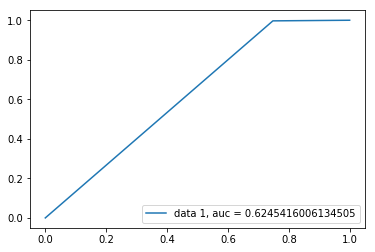

In [38]:
#Code to print the ROC curve
fpr, tpr, _ = metrics.roc_curve(food_review_sample['sentiment'],  predicted)
auc = metrics.roc_auc_score(food_review_sample['sentiment'], predicted)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc)) #Area under curve
plt.legend(loc=4)
plt.show()

In [105]:
f1_score(food_review_sample['sentiment'], predicted, average='weighted')  

0.8555072387876403

In [118]:
#Performing logistic regression with 10-fold CV with adding helpfulness score as well
predicted = cross_validation.cross_val_predict(LogisticRegression(), pd.concat([tfidf_df.reset_index(drop=True), food_review_sample['helpfulness_score']], axis=1), food_review_sample['sentiment'], cv=10)
print(metrics.accuracy_score(food_review_sample['sentiment'], predicted))

0.8858230256898192


88.582% Accuracy. A very slight increase on adding helpfulness score in the mix.

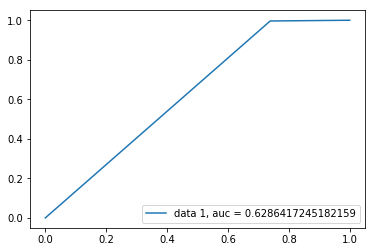

In [119]:
#Code to print the ROC curve
fpr, tpr, _ = metrics.roc_curve(food_review_sample['sentiment'],  predicted)
auc = metrics.roc_auc_score(food_review_sample['sentiment'], predicted)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc)) #Area under curve
plt.legend(loc=4)
plt.show()

In [120]:
f1_score(food_review_sample['sentiment'], predicted, average='weighted')  

0.8572960773775343

In [106]:
#TF_IDF
clf = tree.DecisionTreeClassifier()
clf = clf.fit(tfidf_df.iloc[test_index], food_review_sample.iloc[test_index]['sentiment'])

In [107]:
metrics.accuracy_score(food_review_sample.iloc[valid_index]['sentiment'], clf.predict(tfidf_df.iloc[valid_index]))

0.8389346861128726

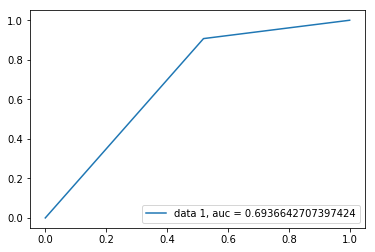

In [108]:
#Code to print the ROC curve
fpr, tpr, _ = metrics.roc_curve(food_review_sample.iloc[valid_index]['sentiment'],  clf.predict(tfidf_df.iloc[valid_index]))
auc = metrics.roc_auc_score(food_review_sample.iloc[valid_index]['sentiment'],  clf.predict(tfidf_df.iloc[valid_index]))
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc)) #Area under curve
plt.legend(loc=4)
plt.show()

In [109]:
f1_score(food_review_sample.iloc[valid_index]['sentiment'],  clf.predict(tfidf_df.iloc[valid_index]), average='weighted')  

0.8378781580156373

As the decision trees give worse results than the logistic regression on the TF-IDF as well, we won't use it

In [40]:
lda_df.index = range(0, len(lda_df))

#### Combining TF-IDF and LDA

In [41]:
#Performing logistic regression with 10-fold CV
predicted = cross_validation.cross_val_predict(LogisticRegression(), pd.concat([tfidf_df.reset_index(drop=True), lda_df], axis=1), food_review_sample['sentiment'], cv=10)
print(metrics.accuracy_score(food_review_sample['sentiment'], predicted))

0.89058039961941


89% Accuracy. Slight increase.

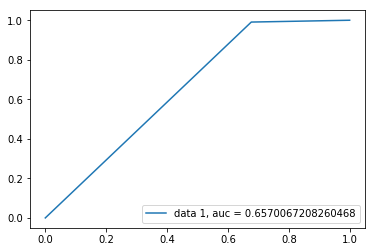

In [42]:
#Code to print the ROC curve
fpr, tpr, _ = metrics.roc_curve(food_review_sample['sentiment'],  predicted)
auc = metrics.roc_auc_score(food_review_sample['sentiment'], predicted)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc)) #Area under curve
plt.legend(loc=4)
plt.show()

In [43]:
f1_score(food_review_sample['sentiment'], predicted, average='weighted')  

0.8685832199782046

#### Using bigram word2vec

In [44]:
#Packages to get a bigram word2vec
from gensim.models.phrases import Phrases, Phraser

In [45]:
bigram = Phrases(list(food_review_sample['review_tokens']), min_count=1, threshold=2, delimiter=b' ')
bigram_phraser = Phraser(bigram)
food_review_sample['review_tokens'] = bigram_phraser[list(food_review_sample['review_tokens'])]

In [46]:
model = Word2Vec(food_review_sample.review_tokens, size=100, window=5, min_count=1, workers=4)

In [47]:
def get_mean(x):
    # Gets the mean of the sentence so that the sentence is represented in the 100-d space
    x = pd.DataFrame(x)
    return x.mean()

def get_sum(x):
    # Gets the sum of the sentence so that the sentence is represented in the 100-d space
    x = pd.DataFrame(x)
    return x.sum()
    

In [48]:
food_review_sample.index = range(food_review_sample.shape[0]) 

In [49]:
df_model_avg = []
for i in range(0, len(food_review_sample)):
    #Getting the average over the 100 dimensions
    df_model_avg.append(get_mean(model[food_review_sample.review_tokens[i]]))
    
df_model_avg = pd.DataFrame(df_model_avg)    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
df_model_sum = []
for i in range(0, len(food_review_sample)):
    #Getting the sum over the 100 dimensions
    df_model_sum.append(get_sum(model[food_review_sample.review_tokens[i]]))
    
df_model_sum = pd.DataFrame(df_model_sum)    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
#Performing logistic regression with 10-fold CV
predicted = cross_validation.cross_val_predict(LogisticRegression(), df_model_avg, food_review_sample['sentiment'], cv=10)
print(metrics.accuracy_score(food_review_sample['sentiment'], predicted))

0.8498572787821123


Accuracy of this is 84.98%.

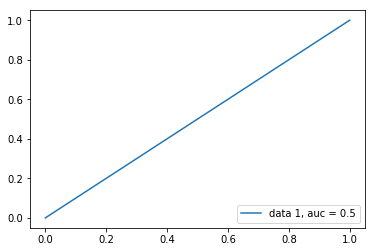

In [53]:
#Code to print the ROC curve
fpr, tpr, _ = metrics.roc_curve(food_review_sample['sentiment'],  predicted)
auc = metrics.roc_auc_score(food_review_sample['sentiment'], predicted)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc)) #Area under curve
plt.legend(loc=4)
plt.show()

In [54]:
f1_score(food_review_sample['sentiment'], predicted, average='weighted')  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7808790468143018

In [55]:
#Performing logistic regression with 10-fold CV
predicted = cross_validation.cross_val_predict(LogisticRegression(), df_model_sum, food_review_sample['sentiment'], cv=10)
print(metrics.accuracy_score(food_review_sample['sentiment'], predicted))

0.850047573739296


Accuracy of this is 85%.

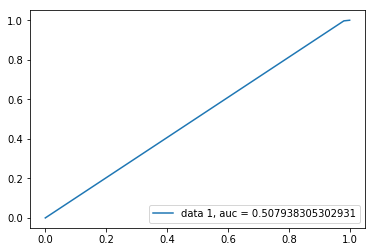

In [56]:
#Code to print the ROC curve
fpr, tpr, _ = metrics.roc_curve(food_review_sample['sentiment'],  predicted)
auc = metrics.roc_auc_score(food_review_sample['sentiment'], predicted)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc)) #Area under curve
plt.legend(loc=4)
plt.show()

In [57]:
f1_score(food_review_sample['sentiment'], predicted, average='weighted')  

0.7862667962520725

#### Combining TF-IDF, Word2Vec and LDA

In [58]:
#Performing logistic regression with 10-fold CV
predicted = cross_validation.cross_val_predict(LogisticRegression(), pd.concat([tfidf_df.reset_index(drop=True), lda_df, df_model_avg], axis=1), food_review_sample['sentiment'], cv=10)
print(metrics.accuracy_score(food_review_sample['sentiment'], predicted))

0.8913415794481446


Accuracy of this is 89.13%.

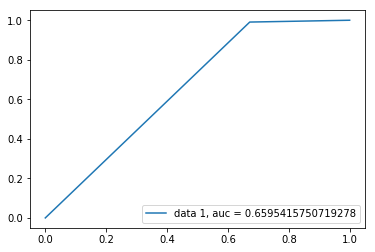

In [59]:
#Code to print the ROC curve
fpr, tpr, _ = metrics.roc_curve(food_review_sample['sentiment'],  predicted)
auc = metrics.roc_auc_score(food_review_sample['sentiment'], predicted)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc)) #Area under curve
plt.legend(loc=4)
plt.show()

In [60]:
f1_score(food_review_sample['sentiment'], predicted, average='weighted')  

0.8697657932910535

#### Combining TF-IDF and Word2Vec

In [61]:
#Performing logistic regression with 10-fold CV
predicted = cross_validation.cross_val_predict(LogisticRegression(), pd.concat([tfidf_df.reset_index(drop=True), df_model_avg], axis=1), food_review_sample['sentiment'], cv=10)
print(metrics.accuracy_score(food_review_sample['sentiment'], predicted))

0.8858230256898192


Accuracy of this is 88.58%.

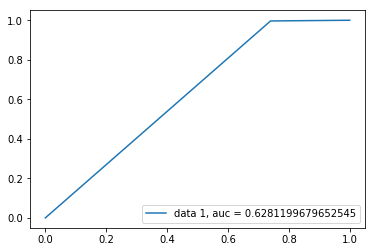

In [62]:
#Code to print the ROC curve
fpr, tpr, _ = metrics.roc_curve(food_review_sample['sentiment'],  predicted)
auc = metrics.roc_auc_score(food_review_sample['sentiment'], predicted)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc)) #Area under curve
plt.legend(loc=4)
plt.show()

In [63]:
f1_score(food_review_sample['sentiment'], predicted, average='weighted')  

0.8571311076723378

#### Combining LDA and Word2Vec

In [64]:
#Performing logistic regression with 10-fold CV
predicted = cross_validation.cross_val_predict(LogisticRegression(), pd.concat([lda_df.reset_index(drop=True), df_model_avg], axis=1), food_review_sample['sentiment'], cv=10)
print(metrics.accuracy_score(food_review_sample['sentiment'], predicted))

0.8607040913415794


Accuracy of this is 86.07%.

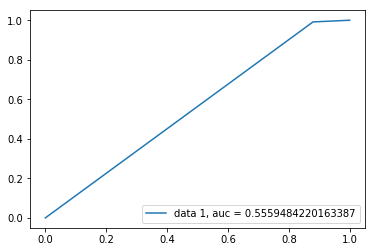

In [65]:
#Code to print the ROC curve
fpr, tpr, _ = metrics.roc_curve(food_review_sample['sentiment'],  predicted)
auc = metrics.roc_auc_score(food_review_sample['sentiment'], predicted)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc)) #Area under curve
plt.legend(loc=4)
plt.show()

In [66]:
f1_score(food_review_sample['sentiment'], predicted, average='weighted')  

0.815915031877527

## Building the model on the whole of the dataset

## Text processing

#### Tokenize the words after converting the text to lower case

In [8]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import nltk
#nltk.download('punkt')

In [ ]:
food_reviews['review_tokens'] = food_reviews.text.str.lower().apply(lambda x: word_tokenize(x))
#food_reviews['review_tokens'] = food_reviews.text_ext.str.lower().apply(lambda x: word_tokenize(x)) # use this...

#### Remove stop words, stemming, and punctuations. 

In [9]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
# nltk.download()

In [ ]:
stemmer = PorterStemmer()
food_reviews['review_tokens'] = food_reviews['review_tokens'].apply(lambda x: [stemmer.stem(words) for words in x])

In [ ]:
def remove_punctuations_and_stopwords(x):
    y = []
    stop_words = set(stopwords.words('english'))
    for i in range(len(x)):
        if x[i].isalnum() and x[i] not in stop_words:
            y.extend([x[i]])
    return y        

In [ ]:
food_reviews['review_tokens'] = food_reviews['review_tokens'].apply(remove_punctuations_and_stopwords)

### Saving word2vec model. Use it load in the future.

In [ ]:
model = Word2Vec(food_reviews.review_tokens, size=100, window=5, min_count=1, workers=4)
model.save("word2vec_binary.model")

In [ ]:
food_reviews['review_tokens']

In [ ]:
pd.DataFrame(model[food_reviews.review_tokens[0]])

## Model Building

In [ ]:
def get_mean(x):
    # Gets the mean of the sentence so that the sentence is represented in the 100-d space
    x = pd.DataFrame(x)
    return x.mean()

def get_sum(x):
    # Gets the sum of the sentence so that the sentence is represented in the 100-d space
    x = pd.DataFrame(x)
    return x.sum()
    

In [ ]:
food_reviews.index = range(food_reviews.shape[0]) 

In [ ]:
df_model_avg = []
for i in range(0, len(food_reviews)):
    df_model_avg.append(get_mean(model[food_reviews.review_tokens[i]]))
    
df_model_avg = pd.DataFrame(df_model_avg)    

In [ ]:
df_model_sum = []
for i in range(0, len(food_reviews)):
    df_model_sum.append(get_sum(model[food_reviews.review_tokens[i]]))
    
df_model_sum = pd.DataFrame(df_model_sum)    

### Performing logistic regression and cross- validation to get the sentiment

In [ ]:
predicted = cross_validation.cross_val_predict(LogisticRegression(), df_model_avg, food_reviews['sentiment'], cv=10)
print(metrics.accuracy_score(food_reviews['sentiment'], predicted))

Accuracy of this is 90.6%

In [ ]:
predicted = cross_validation.cross_val_predict(LogisticRegression(), df_model_sum, food_reviews['sentiment'], cv=10)
print(metrics.accuracy_score(food_reviews['sentiment'], predicted))

Accuracy of this is 90.18%. It decreased very slightly. Going with the mean model only

### Implementing the same on extended review

In [78]:
food_reviews['review_tokens'] = food_reviews['text_ext'].str.lower().apply(lambda x: word_tokenize(x))

#### Remove stop words, stemming, and punctuations. 

In [80]:
stemmer = PorterStemmer()
food_reviews['review_tokens'] = food_reviews['review_tokens'].apply(lambda x: [stemmer.stem(words) for words in x])

In [ ]:
food_reviews['review_tokens'] = food_reviews['review_tokens'].apply(remove_punctuations_and_stopwords)

### Saving word2vec model. Use it load in the future.

In [ ]:
model = Word2Vec(food_reviews.review_tokens, size=100, window=5, min_count=1, workers=4)
model.save("word2vec_binary_ext.model")

In [ ]:
def get_mean(x):
    # Gets the mean of the sentence so that the sentence is represented in the 100-d space
    x = pd.DataFrame(x)
    return x.mean()

def get_sum(x):
    # Gets the sum of the sentence so that the sentence is represented in the 100-d space
    x = pd.DataFrame(x)
    return x.sum()
    

In [ ]:
food_reviews.index = range(food_reviews.shape[0]) 

In [ ]:
df_model_avg = []
for i in range(0, len(food_reviews)):
    df_model_avg.append(get_mean(model[food_reviews.review_tokens[i]]))
    
df_model_avg = pd.DataFrame(df_model_avg)    

In [ ]:
df_model_sum = []
for i in range(0, len(food_reviews)):
    df_model_sum.append(get_sum(model[food_reviews.review_tokens[i]]))
    
df_model_sum = pd.DataFrame(df_model_sum)    

#### Performing logistic regression and cross- validation to get the sentiment

In [ ]:
predicted = cross_validation.cross_val_predict(LogisticRegression(), df_model_avg, food_reviews['sentiment'], cv=10)
print(metrics.accuracy_score(food_reviews['sentiment'], predicted))

Accuracy of this is 92.14%

In [ ]:
predicted = cross_validation.cross_val_predict(LogisticRegression(), df_model_sum, food_reviews['sentiment'], cv=10)
print(metrics.accuracy_score(food_reviews['sentiment'], predicted))

Accuracy of this is 91.91%. It decreased very slightly. Going with the mean model.

#### Adding helphulness score as well

In [63]:
predicted = cross_validation.cross_val_predict(LogisticRegression(), pd.concat([df_model_avg.reset_index(drop=True), food_reviews['helpfulness_score']], axis=1), food_reviews['sentiment'], cv=10)
print(metrics.accuracy_score(food_reviews['sentiment'], predicted))

0.9215998782784002


In [64]:
word_2_vec_df = pd.concat([df_model_avg.reset_index(drop=True), food_reviews['helpfulness_score'], food_reviews['text_ext'].str.split().str.len()], axis=1)

In [65]:
predicted = cross_validation.cross_val_predict(LogisticRegression(), word_2_vec_df, food_reviews['sentiment'], cv=10)
print(metrics.accuracy_score(food_reviews['sentiment'], predicted))

0.9213621407786379


### Implementing bigrams

In [158]:
from gensim.models.phrases import Phrases, Phraser

In [193]:
bigram = Phrases(list(food_reviews['review_tokens']), min_count=1, threshold=2, delimiter=b' ')
bigram_phraser = Phraser(bigram)
food_reviews['review_tokens'] = bigram_phraser[list(food_reviews['review_tokens'])]

### Saving word2vec model. Use it load in the future.

In [194]:
model = Word2Vec(food_reviews.review_tokens, size=100, window=5, min_count=1, workers=4)
model.save("word2vec_binary_bigram.model")

In [195]:
def get_mean(x):
    # Gets the mean of the sentence so that the sentence is represented in the 100-d space
    x = pd.DataFrame(x)
    return x.mean()

def get_sum(x):
    # Gets the sum of the sentence so that the sentence is represented in the 100-d space
    x = pd.DataFrame(x)
    return x.sum()
    

In [196]:
food_reviews.index = range(food_reviews.shape[0]) 

In [197]:
df_model_avg = []
for i in range(0, len(food_reviews)):
    df_model_avg.append(get_mean(model[food_reviews.review_tokens[i]]))
    
df_model_avg = pd.DataFrame(df_model_avg)    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [198]:
df_model_sum = []
for i in range(0, len(food_reviews)):
    df_model_sum.append(get_sum(model[food_reviews.review_tokens[i]]))
    
df_model_sum = pd.DataFrame(df_model_sum)    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


### Performing logistic regression and cross- validation to get the sentiment

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import cross_validation

In [200]:
predicted = cross_validation.cross_val_predict(LogisticRegression(), df_model_avg, food_reviews['sentiment'], cv=10)
print(metrics.accuracy_score(food_reviews['sentiment'], predicted))

0.9227315087772685


Accuracy of this is 92.27%, an improvement of 0.13%.

In [201]:
predicted = cross_validation.cross_val_predict(LogisticRegression(), df_model_sum, food_reviews['sentiment'], cv=10)
print(metrics.accuracy_score(food_reviews['sentiment'], predicted))

0.9200517316799482


Slight improvement as compared to the previous sum model to 92% 

### Implementing the same using TF-IDF

In [67]:
from nltk import FreqDist

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [68]:
food_reviews['extended_review_processed'] = food_reviews['text_ext'].apply(lambda x: " ".join(x.lower() for x in x.split()))
stop_words = set(stopwords.words('english'))
food_reviews['extended_review_processed'] = food_reviews['extended_review_processed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))


In [69]:
stemmer = PorterStemmer()
food_reviews['extended_review_processed'] = food_reviews['extended_review_processed'].apply(lambda x: [stemmer.stem(words) for words in x.split(' ')])

In [70]:
food_reviews['extended_review_processed'] = food_reviews['extended_review_processed'].apply(lambda x : ' '.join(x))

In [71]:
vectorizer = TfidfVectorizer(max_df = 0.8, max_features=3000)
tfidf = vectorizer.fit_transform(food_reviews['extended_review_processed'])


In [72]:
feature_names = vectorizer.get_feature_names()
corpus_index = food_reviews.index
tfidf_df = pd.DataFrame(tfidf.todense(), columns=feature_names)

### Performing logistic regression and 10 fold cross- validation to get the sentiment

In [73]:
tfidf.shape

(525535, 3000)

In [74]:
predicted = cross_validation.cross_val_predict(LogisticRegression(), tfidf, food_reviews['sentiment'], cv=10)
print(metrics.accuracy_score(food_reviews['sentiment'], predicted))

0.9385445308114588


The TF-IDF method gives an accuracy of 93.85%

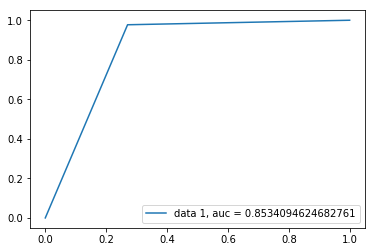

In [75]:
#Code to print the ROC curve
fpr, tpr, _ = metrics.roc_curve(food_reviews['sentiment'],  predicted)
auc = metrics.roc_auc_score(food_reviews['sentiment'], predicted)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc)) #Area under curve
plt.legend(loc=4)
plt.show()

Calculating the f1-score

In [77]:
f1_score(food_reviews['sentiment'], predicted, average='weighted')  

0.9365223679217642